In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import seaborn as sns
import os.path

In [2]:
panj = pd.read_pickle("./panj_outlier.pkl")  
dnevnik = pd.read_pickle('./dnevnik_cleaned.pkl')
vreme = pd.read_pickle('./vreme_cleaned.pkl')

Kalkuliramo vlaznost glede na https://www.timberaid.com/calculator/fundamental/moisturecontent.
Vlaznost h v panju mora biti v procentih, T pa v celzijah

In [3]:
def EMC(T, h):
  T = (T - 32) * (5/9)
  h = h/100
  W = 330+0.452+T+0.00415*T**2
  K = 0.791+0.000463*T-0.000000844*T**2
  K1 = 6.34+0.000463*T-0.000000844*T**2
  K2 = 1.09+0.0284*T-0.0000904*T**2
  return (1800/W) * (((K*h)/(1-K*h))+(K1*K*h+2*K1*K2*K**2*h**2)/(1+K1*K*h+K1*K2*K**2*h**2))

In še izračun suhe teže panja

In [4]:
def teza(EMC, mokra_teza):
  return mokra_teza / ((EMC/100)+1)

In [5]:
vreme.head()

,date,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Ch,VV,Td,RRR,tR,E,Tg,E',sss,???
0,2020-02-05 23:00:00,7.6,752.5,755.7,1.5,95.0,Wind blowing from the west-northwest,3,NaN,NaN,...,NaN,20.0,6.9,0,NaN,NaN,NaN,NaN,0.0,0.0
1,2020-02-05 22:00:00,8.3,752.0,755.1,1.4,92.0,Wind blowing from the west-northwest,4,NaN,NaN,...,NaN,45.0,7.0,0,NaN,NaN,NaN,NaN,0.0,0.0
2,2020-02-05 21:00:00,7.8,751.6,754.7,1.5,91.0,Wind blowing from the west,2,NaN,NaN,...,NaN,35.0,6.4,0,NaN,NaN,NaN,NaN,0.0,0.0
3,2020-02-05 20:00:00,8.6,751.0,754.0,1.4,86.0,Wind blowing from the west,2,NaN,NaN,...,NaN,50.0,6.4,0.4,12.0,NaN,NaN,NaN,0.0,0.0
4,2020-02-05 19:00:00,10.7,750.6,753.7,1.2,71.0,Wind blowing from the west-northwest,4,NaN,NaN,...,NaN,50.0,5.5,0,NaN,NaN,NaN,NaN,0.0,0.0


In [6]:
EMC(7.6, 96)
teza(EMC(7.6, 96), 23)
teza(EMC(10.7, 71), 23)

20.321496692563027

In [7]:
def create_line_from_nearest_values(df, date_col, value_col):
    # Make sure the DataFrame is sorted by the datetime column
    df = df.sort_values(by=[date_col])

    # Interpolate missing values using linear interpolation
    df[value_col] = df[value_col].interpolate(method='linear')

    return df

In [8]:
vreme = create_line_from_nearest_values(vreme, "date", "T")
vreme = create_line_from_nearest_values(vreme, "date", "U")

In [9]:
vreme[["T", "U"]] = vreme[["T", "U"]].apply(pd.to_numeric)

In [10]:
vreme['EMC'] = vreme.apply(lambda x: EMC(x["T"], x["U"]), axis=1)

In [11]:
vreme.head()

,date,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,VV,Td,RRR,tR,E,Tg,E',sss,???,EMC
8008,2019-01-06 00:00:00,13.2,762.7,765.7,0.2,97.0,Wind blowing from the south-west,3,NaN,NaN,...,7.0,12.8,0,NaN,NaN,NaN,NaN,0.0,0.0,24.864452
8007,2019-01-06 01:00:00,13.7,762.4,765.5,-0.2,96.0,Wind blowing from the west-southwest,3,NaN,NaN,...,9.0,13.1,0,NaN,NaN,NaN,NaN,0.0,0.0,24.092378
8006,2019-01-06 02:00:00,13.6,762.1,765.2,-0.6,97.0,Wind blowing from the south-southwest,2,NaN,NaN,...,6.0,13.1,0.1,6.0,NaN,NaN,NaN,0.0,0.0,24.871793
8005,2019-01-06 03:00:00,13.0,762.0,765.1,-0.7,97.0,Wind blowing from the south-west,3,NaN,NaN,...,3.7,12.6,0,NaN,NaN,NaN,NaN,0.0,0.0,24.860733
8004,2019-01-06 04:00:00,12.5,761.9,765.1,-0.5,97.0,Wind blowing from the south-west,3,NaN,NaN,...,2.9,12.0,0,NaN,NaN,NaN,NaN,0.0,0.0,24.851297


In [12]:
panj.head()

,resId,siteNo,hiveNo,frameNo,hour,paramText,anMethText,resVal,resUnit,resUnit_desc,resValUncert,resValUncertSD,resQualValue,date,year,month
162858,CW207781,3,1,NaN,0,Colony weight,Automatic recording,24.6,G167A,Kilogram,NaN,NaN,NaN,2019-06-01 00:00:00,2019,6
162857,CW207782,3,1,NaN,1,Colony weight,Automatic recording,24.6,G167A,Kilogram,NaN,NaN,NaN,2019-06-01 01:00:00,2019,6
162855,CW207783,3,1,NaN,2,Colony weight,Automatic recording,24.5,G167A,Kilogram,NaN,NaN,NaN,2019-06-01 02:00:00,2019,6
162854,CW207784,3,1,NaN,3,Colony weight,Automatic recording,24.5,G167A,Kilogram,NaN,NaN,NaN,2019-06-01 03:00:00,2019,6
162853,CW207785,3,1,NaN,4,Colony weight,Automatic recording,24.5,G167A,Kilogram,NaN,NaN,NaN,2019-06-01 04:00:00,2019,6


In [13]:
df = pd.merge(panj, vreme, left_on='date', right_on='date')

In [14]:
df.head()

,resId,siteNo,hiveNo,frameNo,hour,paramText,anMethText,resVal,resUnit,resUnit_desc,...,VV,Td,RRR,tR,E,Tg,E',sss,???,EMC
0,CW207872,3,1,NaN,0,Colony weight,Automatic recording,24.6,G167A,Kilogram,...,30.0,1.6,0,NaN,NaN,NaN,NaN,0.0,0.0,14.796384
1,CW207873,3,1,NaN,1,Colony weight,Automatic recording,24.6,G167A,Kilogram,...,25.0,2.0,0,NaN,NaN,NaN,NaN,0.0,0.0,16.500240
2,CW207874,3,1,NaN,2,Colony weight,Automatic recording,24.6,G167A,Kilogram,...,23.0,2.3,0,NaN,NaN,NaN,NaN,0.0,0.0,16.139005
3,CW207875,3,1,NaN,3,Colony weight,Automatic recording,24.6,G167A,Kilogram,...,21.0,2.5,0,NaN,NaN,NaN,NaN,0.0,0.0,16.890129
4,CW207876,3,1,NaN,4,Colony weight,Automatic recording,24.6,G167A,Kilogram,...,21.0,3.0,0,NaN,NaN,NaN,NaN,0.0,0.0,17.298081


In [15]:
df['suha_teza'] = df.apply(lambda x: teza(x["EMC"], x["resVal"]), axis=1)

In [16]:
df.head()

,resId,siteNo,hiveNo,frameNo,hour,paramText,anMethText,resVal,resUnit,resUnit_desc,...,Td,RRR,tR,E,Tg,E',sss,???,EMC,suha_teza
0,CW207872,3,1,NaN,0,Colony weight,Automatic recording,24.6,G167A,Kilogram,...,1.6,0,NaN,NaN,NaN,NaN,0.0,0.0,14.796384,21.429246
1,CW207873,3,1,NaN,1,Colony weight,Automatic recording,24.6,G167A,Kilogram,...,2.0,0,NaN,NaN,NaN,NaN,0.0,0.0,16.500240,21.115836
2,CW207874,3,1,NaN,2,Colony weight,Automatic recording,24.6,G167A,Kilogram,...,2.3,0,NaN,NaN,NaN,NaN,0.0,0.0,16.139005,21.181514
3,CW207875,3,1,NaN,3,Colony weight,Automatic recording,24.6,G167A,Kilogram,...,2.5,0,NaN,NaN,NaN,NaN,0.0,0.0,16.890129,21.045404
4,CW207876,3,1,NaN,4,Colony weight,Automatic recording,24.6,G167A,Kilogram,...,3.0,0,NaN,NaN,NaN,NaN,0.0,0.0,17.298081,20.972210


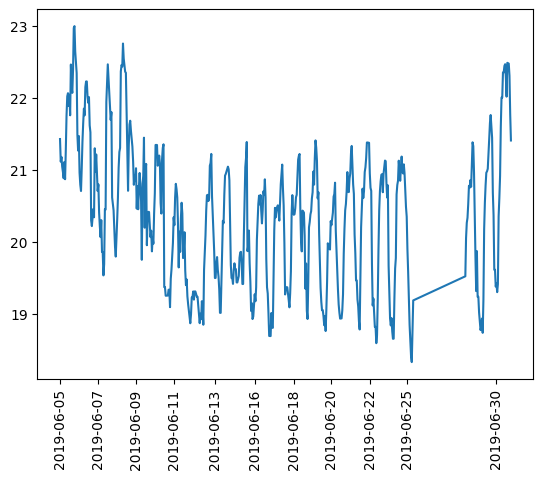

In [17]:
plt.plot(df['date'], df['suha_teza'], '-')
plt.xticks(df['date'][::50],  rotation='vertical')
plt.show()